In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, GridSearchCV, cross_val_score, ParameterGrid

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
sns.set_palette('muted')
sns.set_color_codes()

In [4]:
df, cut_dict = comp.load_sim(return_cut_dict=True)
selection_mask = np.array([True] * len(df))
standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
                     'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
# standard_cut_keys = ['lap_reco_success', 'lap_zenith', 'num_hits_1_30', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_30', 'lap_containment', 'energy_range_lap']
# standard_cut_keys = ['reco_exists', 'reco_zenith', 'num_hits_1_60', 'IT_signal',
#                      'StationDensity', 'max_qfrac_1_60', 'reco_containment', 'energy_range']
for key in standard_cut_keys:
    selection_mask *= cut_dict[key]

df = df[selection_mask]

feature_list, feature_labels = comp.get_training_features()
print('training features = {}'.format(feature_list))
X_train, X_test, y_train, y_test, le = comp.get_train_test_sets(
    df, feature_list, train_he=False)

print('number training events = ' + str(y_train.shape[0]))

/home/jbourbeau/cr-composition/composition/load_sim.py:109: RuntimeWarning: divide by zero encountered in log10
  df['log_NChannels_1_30'] = np.nan_to_num(np.log10(df['NChannels_1_30']))


training features = ['lap_log_energy', 'InIce_log_charge_1_30', 'lap_cos_zenith', 'NChannels_1_30', 'log_s125']
number training events = 62061


In [5]:
X_train[:100, 0], le.inverse_transform(y_train)[:100]

(array([ 7.22166668,  7.15309231,  6.46384395,  7.4445823 ,  6.37377915,
         6.42744612,  7.47468659,  7.74911432,  6.58125106,  7.07874409,
         6.33434411,  6.48072847,  6.7064637 ,  7.35193185,  7.33710386,
         6.42501247,  6.8898205 ,  7.57316938,  6.32982608,  7.56544937,
         6.79412385,  6.39959349,  7.92305639,  6.33486231,  6.72071134,
         6.65701793,  6.30567319,  6.43269084,  6.32231405,  6.6192436 ,
         7.83623325,  7.92620056,  7.53989009,  7.69656281,  7.04974679,
         6.64903866,  7.81838937,  7.07268947,  6.76175809,  7.09033576,
         6.21400529,  6.28703506,  7.39012674,  7.85495455,  6.76515682,
         6.65726055,  6.43083559,  6.92466793,  7.20316408,  7.65420361,
         6.43047172,  6.28406484,  7.6547485 ,  6.20070019,  6.29404821,
         6.58007225,  6.34824144,  6.7084409 ,  7.89780228,  6.74622707,
         6.61826559,  6.28873911,  6.47225926,  7.42368858,  7.09250094,
         6.90205566,  6.65894608,  6.24611082,  6.7

Get error in charge vs. energy distribution

In [7]:
len(df)

156646

In [8]:
pipeline = comp.get_pipeline('RF')
param_range = np.arange(1, 31)
param_grid = {'classifier__max_depth': param_range}
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5,
                  verbose=1,
                  n_jobs=20)
gs = gs.fit(X_train, y_train)
print('best GS CV score = {}'.format(gs.best_score_))
print('best GS CV depths = {}'.format(gs.best_params_))
print('Grid scores on development set:')
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
pipeline.set_params(**gs.best_params_)
pipeline.fit(X_train, y_train)
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 150 out of 150 | elapsed:  1.4min finished


best GS CV score = 0.82172501899
best GS CV depths = {'classifier__max_depth': 13}
Grid scores on development set:
0.654 (+/-0.007) for {'classifier__max_depth': 1}
0.678 (+/-0.008) for {'classifier__max_depth': 2}
0.746 (+/-0.004) for {'classifier__max_depth': 3}
0.784 (+/-0.006) for {'classifier__max_depth': 4}
0.800 (+/-0.007) for {'classifier__max_depth': 5}
0.810 (+/-0.008) for {'classifier__max_depth': 6}
0.814 (+/-0.007) for {'classifier__max_depth': 7}
0.817 (+/-0.005) for {'classifier__max_depth': 8}
0.818 (+/-0.005) for {'classifier__max_depth': 9}
0.820 (+/-0.004) for {'classifier__max_depth': 10}
0.821 (+/-0.005) for {'classifier__max_depth': 11}
0.821 (+/-0.005) for {'classifier__max_depth': 12}
0.822 (+/-0.005) for {'classifier__max_depth': 13}
0.821 (+/-0.005) for {'classifier__max_depth': 14}
0.822 (+/-0.004) for {'classifier__max_depth': 15}
0.821 (+/-0.004) for {'classifier__max_depth': 16}
0.821 (+/-0.005) for {'classifier__max_depth': 17}
0.821 (+/-0.004) for {'clas

In [16]:
pipeline = comp.get_pipeline('RF')
params = {'classifier__max_depth': 5}
pipeline.set_params(**params)
pipeline.fit(X_train, y_train)
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
test_predictions = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
print('Test accuracy: {:.4%}'.format(test_acc))
train_predictions = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_predictions)
print('Train accuracy: {:.4%}'.format(train_acc))
scores = cross_val_score(
    estimator=pipeline, X=X_test, y=y_test, cv=10, n_jobs=10)
print('CV score: {:.2%} (+/- {:.2%})'.format(scores.mean(), scores.std()))
print('=' * 30)

RandomForestClassifier
Test accuracy: 53.2390%
Train accuracy: 80.3613%
CV score: 55.25% (+/- 0.70%)


In [17]:
comp_list = ['P', 'He', 'Fe']
# comp_list = ['P', 'Fe']
# comp_list = le.inverse_transform(np.unique(y_test))

correctly_identified_mask = (test_predictions == y_test)

# Energy-related variables
energy_bin_width = 0.1
energy_bins = np.arange(6.2, 8.1, energy_bin_width)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
log_energy = X_test[:, 0]

# Construct MC composition masks
MC_comp_mask = {}
for composition in comp_list:
    MC_comp_mask[composition] = (le.inverse_transform(y_test) == composition)

# Get number of MC comp in each reco energy bin
num_MC_energy, num_MC_energy_err = {}, {}
for composition in comp_list:
    num_MC_energy[composition] = np.histogram(log_energy[MC_comp_mask[composition]],
                                     bins=energy_bins)[0]
    num_MC_energy_err[composition] = np.sqrt(num_MC_energy[composition])

num_MC_energy['total'] = np.histogram(log_energy, bins=energy_bins)[0]
num_MC_energy_err['total'] = np.sqrt(num_MC_energy['total'])


# Get number of reco comp in each reco energy bin for MC Helium
num_reco_energy, num_reco_energy_err = {}, {}
for composition in comp_list:
    num_reco_energy[composition] = np.histogram(
        log_energy[MC_comp_mask['He'] & (le.inverse_transform(test_predictions) == composition)],
        bins=energy_bins)[0]
    num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

# num_reco_energy['total'] = np.histogram(log_energy[correctly_identified_mask], bins=energy_bins)[0]
# num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])



# # Calculate correctly identified fractions as a function of MC energy
# reco_frac, reco_frac_err = {}, {}
# for composition in comp_list:
#     print(composition)
#     reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
#         num_reco_energy[composition], num_reco_energy_err[composition],
#         num_MC_energy[composition], num_MC_energy_err[composition])
    
# reco_frac['total'], reco_frac_err['total'] = comp.ratio_error(
#         num_reco_energy['total'], num_reco_energy_err['total'],
#         num_MC_energy['total'], num_MC_energy_err['total'])

Training features: 
1) $\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$
2) InIce charge (top 50\%)
3) $\cos(\theta_{\mathrm{Lap}})$
4) NChannels (top 50\%)
5) $\log_{10}(S_{\mathrm{125}})$


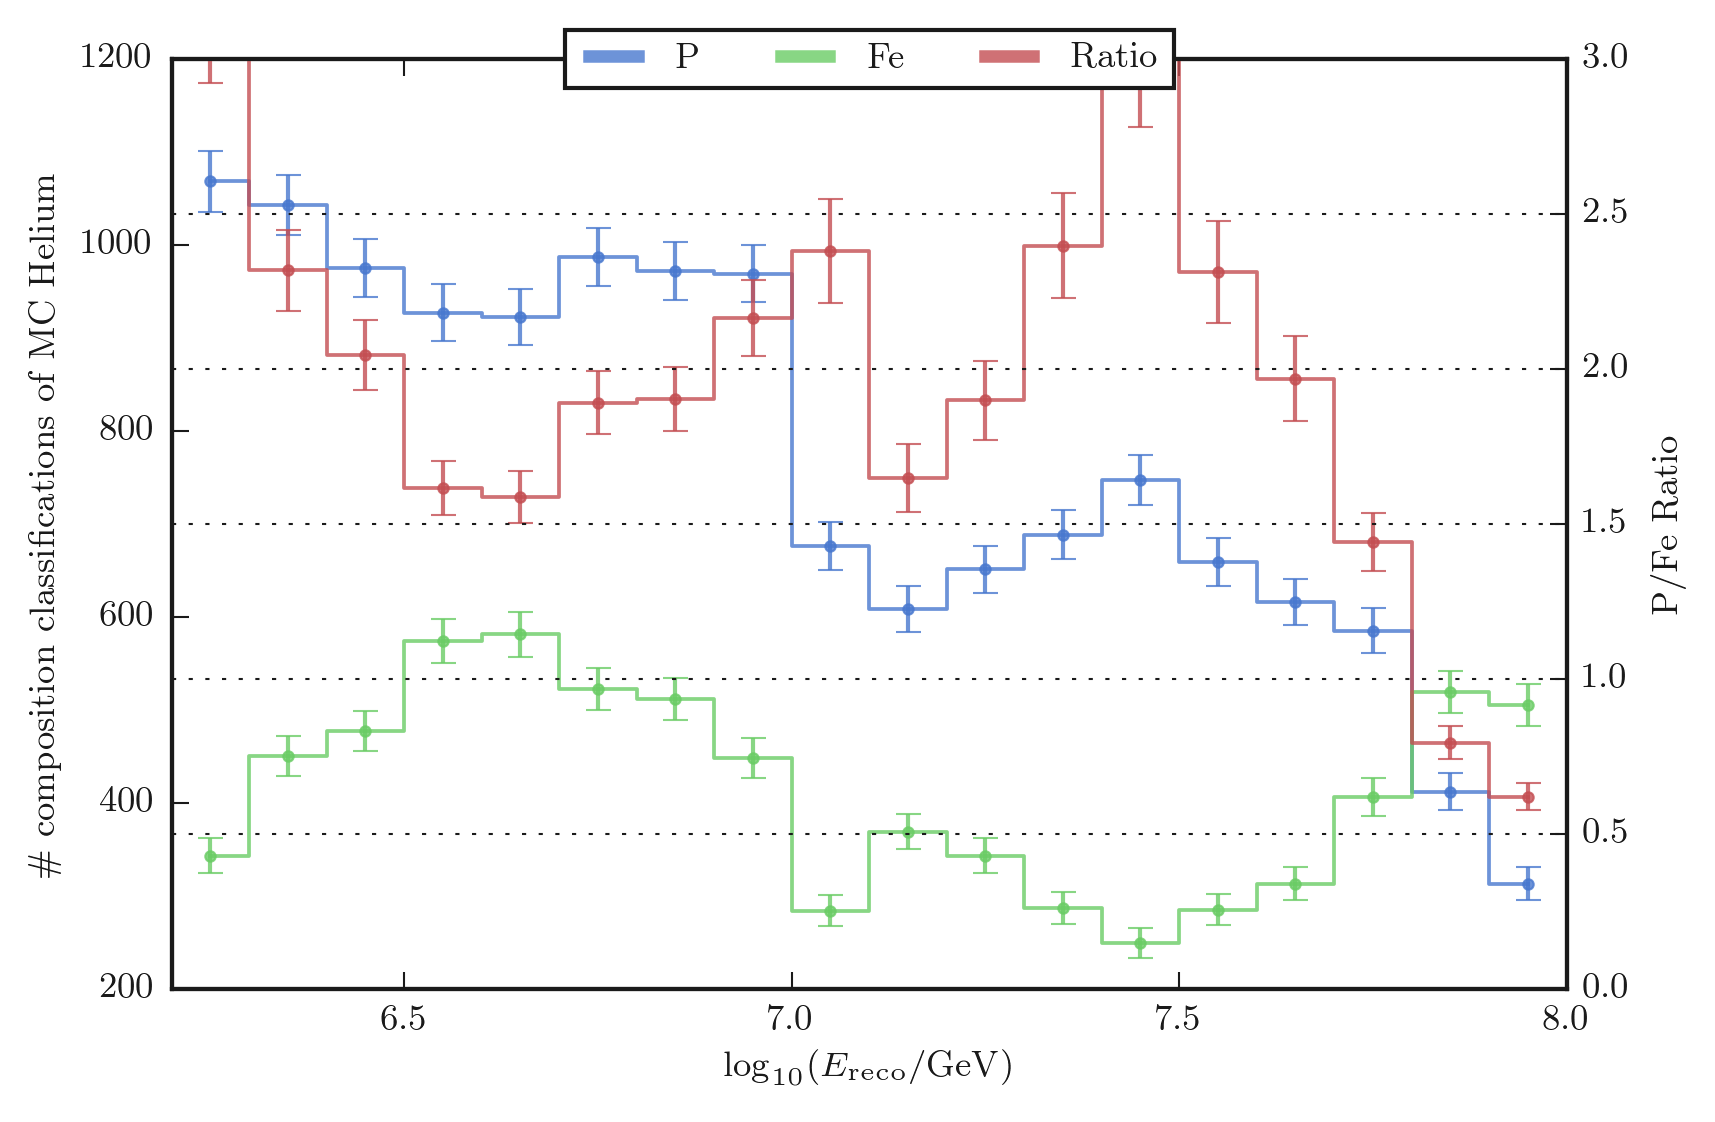

In [18]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
lines = []
for composition in ['P', 'Fe']:
    ebar = ax.errorbar(energy_midpoints, num_reco_energy[composition],
                yerr=num_reco_energy_err[composition],
                # xerr=energy_bin_width / 2,
                marker='.', markersize=5,
                alpha=0.8)
    step = ax.step(energy_midpoints, num_reco_energy[composition], where='mid',
            marker=None, color=ebar[0].get_color(), linewidth=0.9,
            linestyle='-', label=composition, alpha=0.8)
    lines.append(step)
# ebar = ax.errorbar(energy_midpoints, reco_frac['total'],
#                 yerr=reco_frac_err['total'],
#                 # xerr=energy_bin_width / 2,
#                 marker='.', markersize=5,
#                 alpha=0.8)
# ax.step(energy_midpoints, reco_frac['total'], where='mid', marker=None,
#         color=ebar[0].get_color(), linewidth=0.9, label='Total', alpha=0.8)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('\# composition classifications of MC Helium')
# ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
# plt.grid()
# leg = plt.legend(loc=3)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print(textstr)
props = dict(facecolor='white')
# ax.text(1.025, 1.0, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)
ax2 = ax.twinx()
ratio, ratio_err = comp.ratio_error(
        num_reco_energy['P'], num_reco_energy_err['P'],
        num_reco_energy['Fe'], num_reco_energy_err['Fe'])
ebar = ax2.errorbar(energy_midpoints, ratio, yerr=ratio_err, marker='.', markersize=5,
             alpha=0.8, color='r')
step = ax2.step(energy_midpoints, ratio, where='mid', marker=None,
        color=ebar[0].get_color(), linewidth=0.9, label='Ratio', alpha=0.8)
lines.append(step)
ax2.set_ylim([0, 3])
ax2.set_ylabel('P/Fe Ratio')
plt.grid()
# added these three lines
for i, line in enumerate(lines):
    if i == 0:
        lns = line
    else:
        lns += line
labs = [l.get_label() for l in lns]
leg = plt.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(comp_list)+1, fancybox=False, shadow=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# outfile = '/home/jbourbeau/public_html/figures/composition' + \
#           '/fraction-reco-correct_vs_reco-energy_RF.png'
# plt.savefig(outfile)
plt.show()

Training features: 
1) $\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$
2) InIce charge (top 50\%)
3) $\cos(\theta_{\mathrm{Lap}})$
4) NChannels (top 50\%)
5) $\log_{10}(S_{\mathrm{125}})$


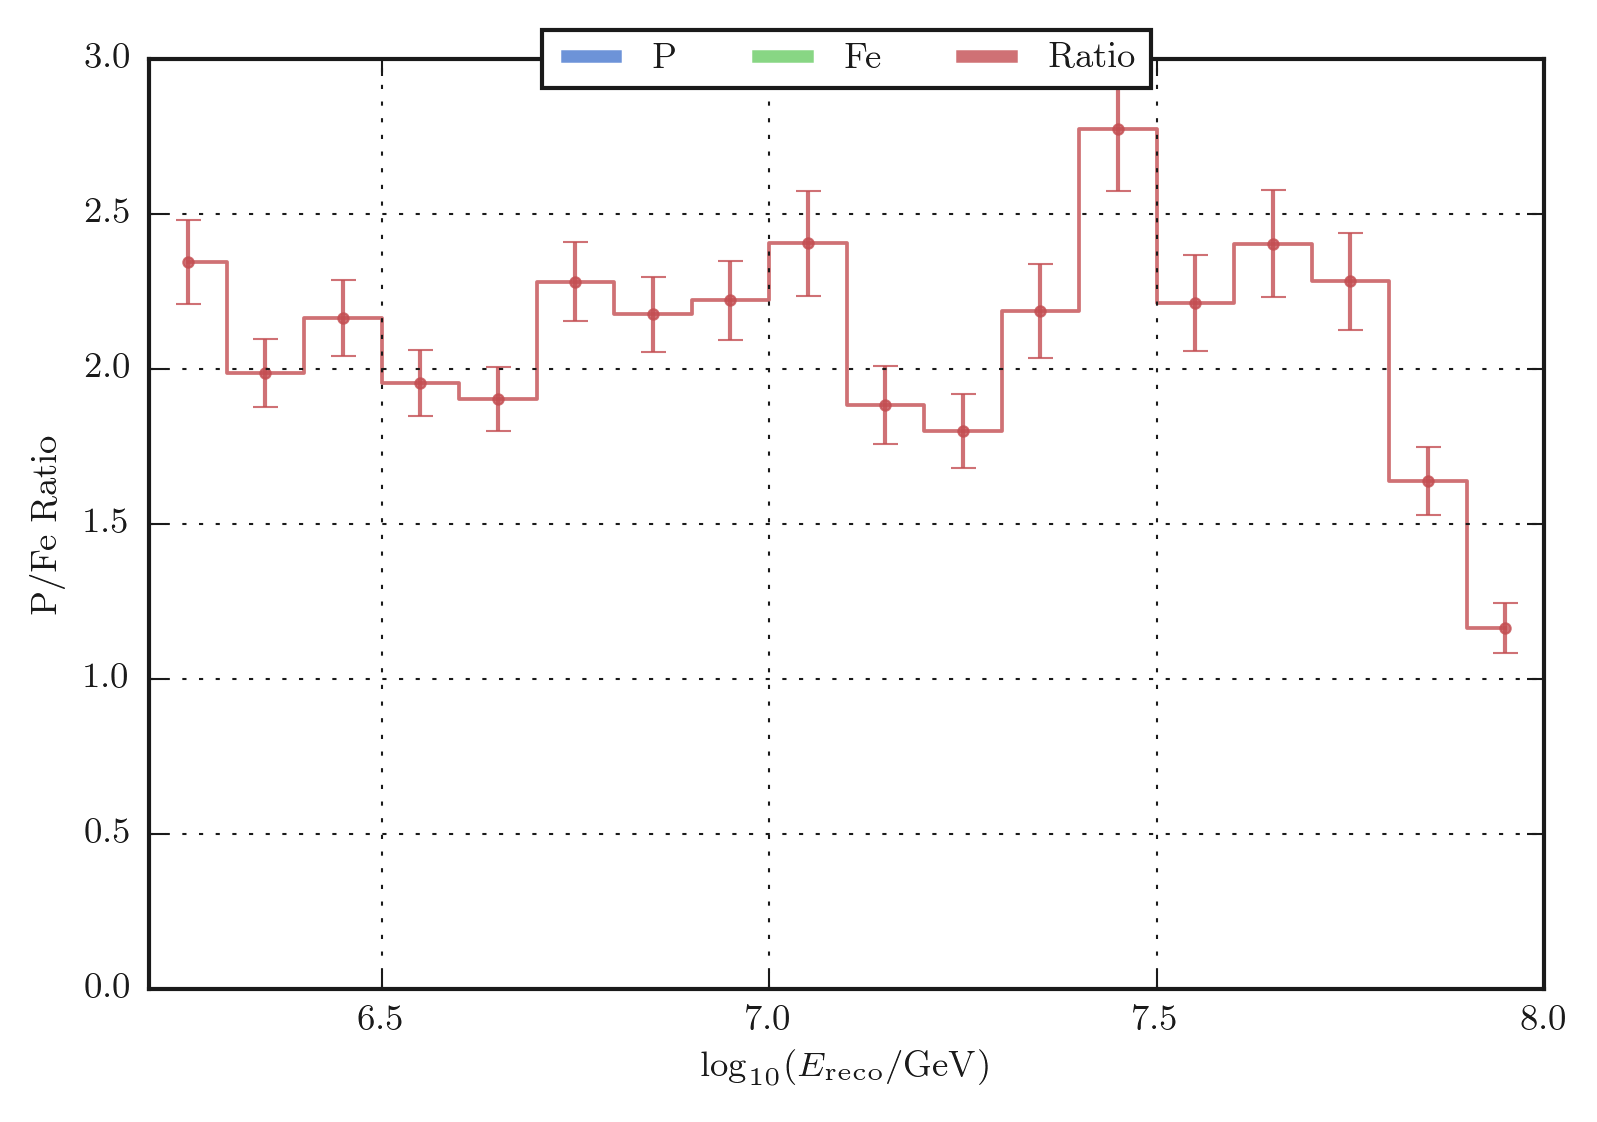

In [9]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
lines = []
ratio, ratio_err = comp.ratio_error(
        num_reco_energy['P'], num_reco_energy_err['P'],
        num_reco_energy['Fe'], num_reco_energy_err['Fe'])
ebar = ax.errorbar(energy_midpoints, ratio, yerr=ratio_err, marker='.', markersize=5,
             alpha=0.8, color='r')
step = ax.step(energy_midpoints, ratio, where='mid', marker=None,
        color=ebar[0].get_color(), linewidth=0.9, label='Ratio', alpha=0.8)
ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('P/Fe Ratio')
ax.set_xlim([6.2, 8.0])
ax.set_ylim([0, 3])
plt.grid()
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print(textstr)
props = dict(facecolor='white')
# added these three lines
for i, line in enumerate(lines):
    if i == 0:
        lns = line
    else:
        lns += line
labs = [l.get_label() for l in lns]
leg = plt.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(comp_list)+1, fancybox=False, shadow=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# outfile = '/home/jbourbeau/public_html/figures/composition' + \
#           '/fraction-reco-correct_vs_reco-energy_RF.png'
# plt.savefig(outfile)
plt.show()

Training features: 
1) $\log_{10}(E_{\mathrm{Lap}}/\mathrm{GeV})$
2) InIce charge (top 50\%)
3) $\cos(\theta_{\mathrm{Lap}})$
4) NChannels (top 50\%)
5) $\log_{10}(S_{\mathrm{125}})$


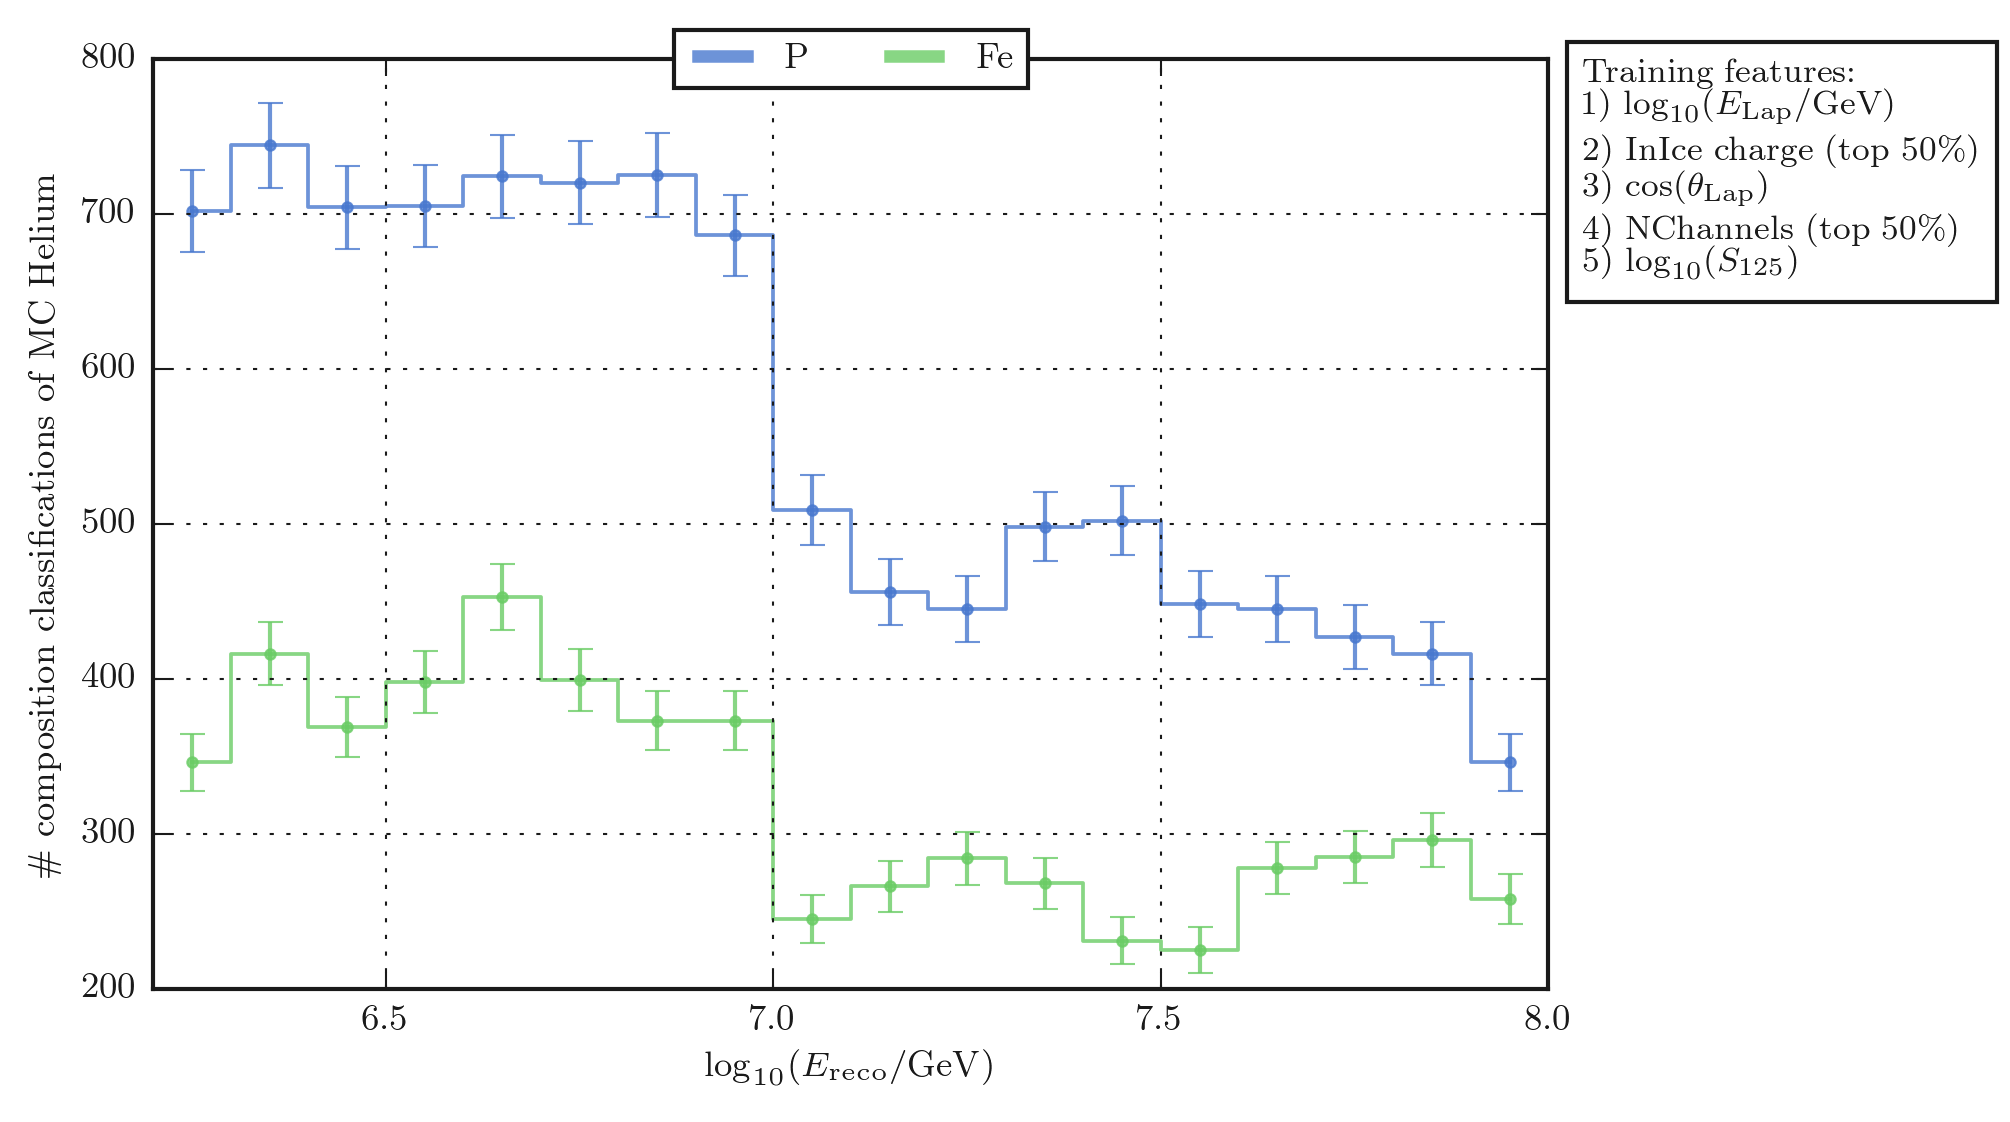

In [11]:
# Plot fraction of events vs energy
fig, ax = plt.subplots()
for composition in ['P', 'Fe']:
    ebar = ax.errorbar(energy_midpoints, num_reco_energy[composition],
                yerr=num_reco_energy_err[composition],
                # xerr=energy_bin_width / 2,
                marker='.', markersize=5,
                alpha=0.8)
    ax.step(energy_midpoints, num_reco_energy[composition], where='mid',
            marker=None, color=ebar[0].get_color(), linewidth=0.9,
            linestyle='-', label=composition, alpha=0.8)
# ebar = ax.errorbar(energy_midpoints, reco_frac['total'],
#                 yerr=reco_frac_err['total'],
#                 # xerr=energy_bin_width / 2,
#                 marker='.', markersize=5,
#                 alpha=0.8)
# ax.step(energy_midpoints, reco_frac['total'], where='mid', marker=None,
#         color=ebar[0].get_color(), linewidth=0.9, label='Total', alpha=0.8)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('\# composition classifications of MC Helium')
# ax.set_ylim([0.0, 1.0])
ax.set_xlim([6.2, 8.0])
# ax.set_xlim([6.2, 9.5])
plt.grid()
# leg = plt.legend(loc=3)
leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=len(comp_list)+1, fancybox=False, shadow=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
# place a text box in upper left in axes coords
textstr = 'Training features: \n'
for i, label in enumerate(feature_labels):
    if (i == len(feature_labels)-1):
        textstr += '{}) '.format(i+1) + label
    else:
        textstr += '{}) '.format(i+1) + label + '\n'
print(textstr)
props = dict(facecolor='white')
# ax.text(0.0, 0.0, textstr, transform=ax.transAxes, fontsize=8,
#         verticalalignment='top', bbox=props)
ax.text(1.025, 1.0, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
outfile = '/home/jbourbeau/public_html/figures/composition' + \
          '/fraction-reco-correct_vs_reco-energy_RF.png'
plt.savefig(outfile)
plt.show()

1) 0.405580146944
2) 0.191784521503
3) 0.162376146696
4) 0.135112657015
5) 0.105146527841


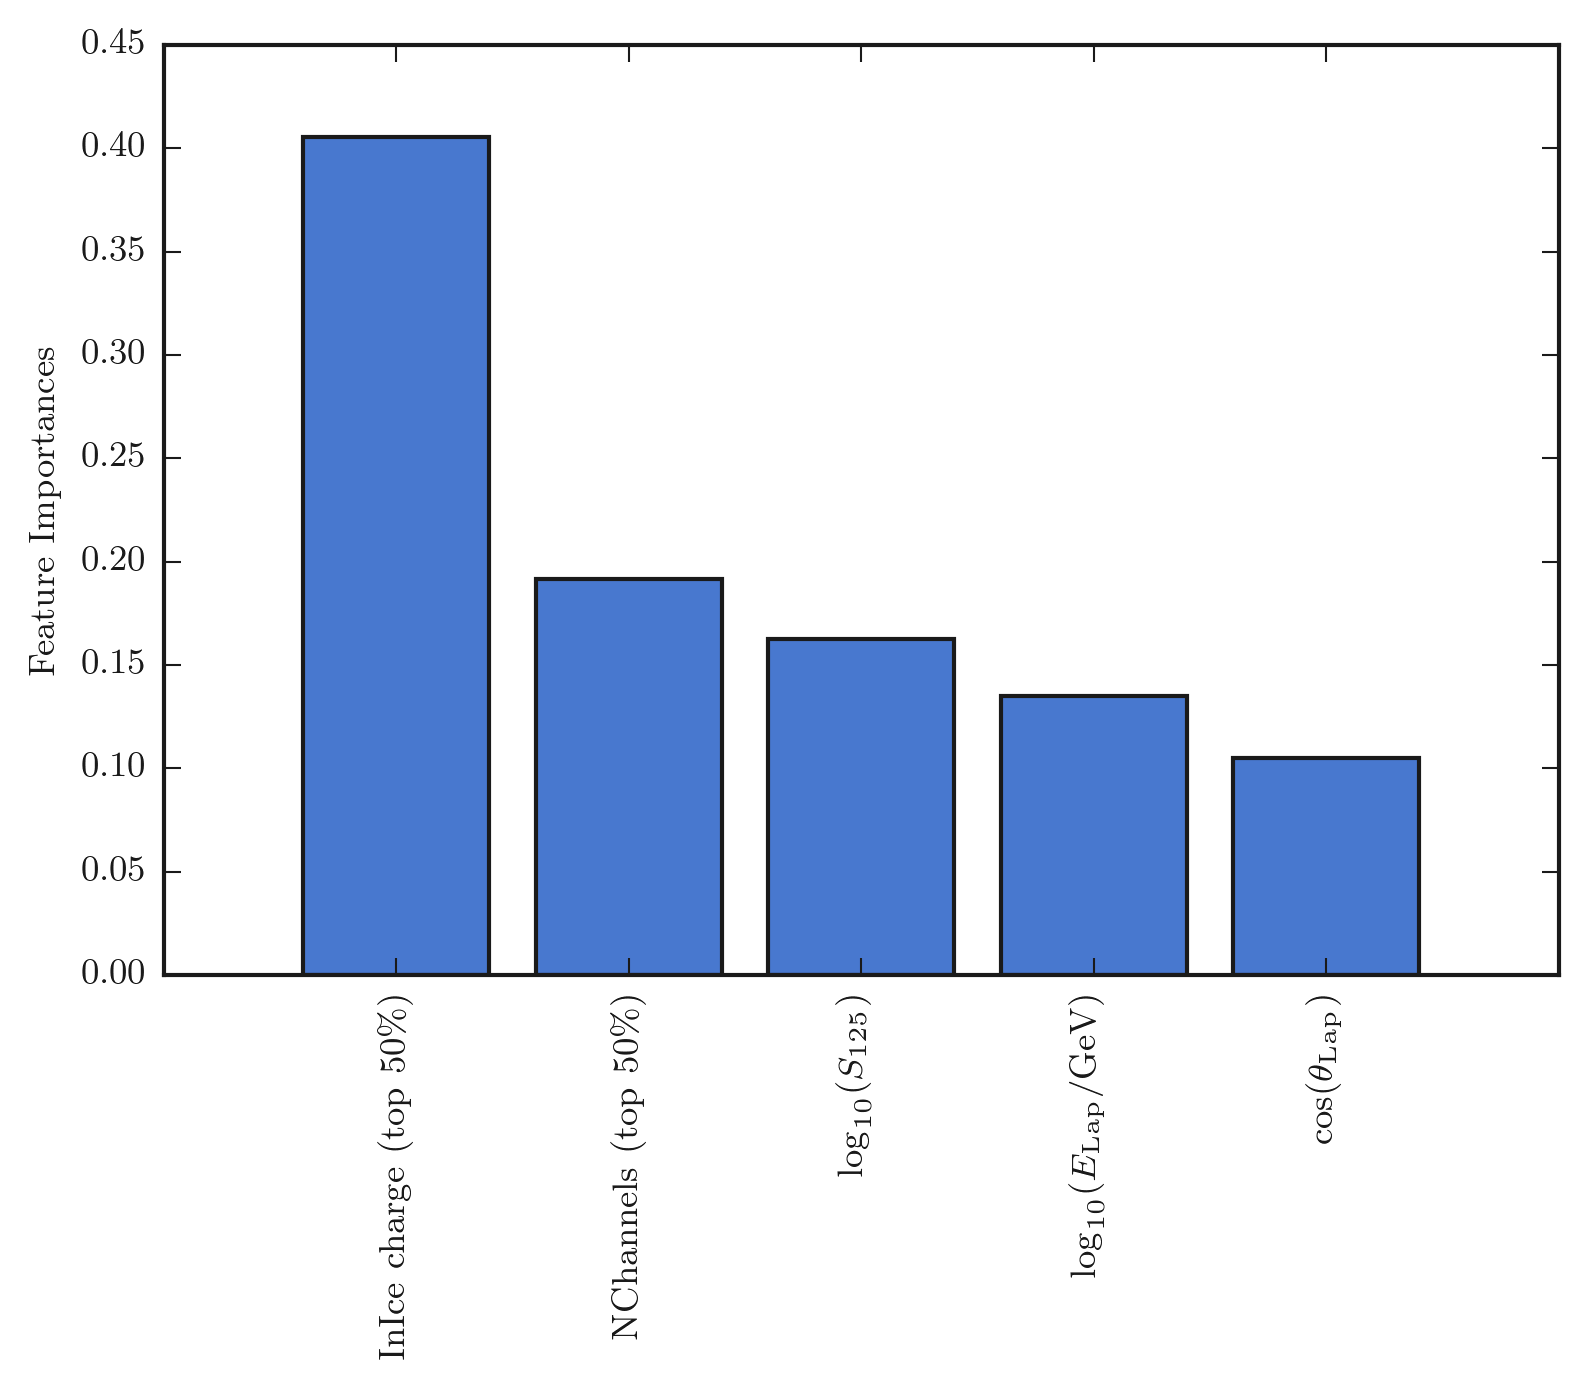

In [12]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
# feature_labels = np.array(['$\\log_{10}({\mathrm{E/GeV})$', 'InIce charge',
#                            '$\cos(\\theta)$', '$\mathrm{Laputop}\ \chi^2/\mathrm{n.d.f.}$', 'NChannels'])
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
# plt.ylim([0, .40])
plt.show()

In [13]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
prob_1 = probs[:, 0][MC_iron_mask]
prob_2 = probs[:, 1][MC_iron_mask]
# print(min(prob_1-prob_2))
# print(max(prob_1-prob_2))
# plt.hist(prob_1-prob_2, bins=30, log=True)
plt.hist(prob_1, bins=np.linspace(0, 1, 50), log=True)
plt.hist(prob_2, bins=np.linspace(0, 1, 50), log=True)

NameError: name 'MC_iron_mask' is not defined

In [ ]:
probs = pipeline.named_steps['classifier'].predict_proba(X_test)
dp1 = (probs[:, 0]-probs[:, 1])[MC_proton_mask]
print(min(dp1))
print(max(dp1))
dp2 = (probs[:, 0]-probs[:, 1])[MC_iron_mask]
print(min(dp2))
print(max(dp2))
fig, ax = plt.subplots()
# plt.hist(prob_1-prob_2, bins=30, log=True)
counts, edges, pathes = plt.hist(dp1, bins=np.linspace(-1, 1, 100), log=True, label='Proton', alpha=0.75)
counts, edges, pathes = plt.hist(dp2, bins=np.linspace(-1, 1, 100), log=True, label='Iron', alpha=0.75)
plt.legend(loc=2)
plt.show()
pipeline.named_steps['classifier'].classes_

In [ ]:
print(pipeline.named_steps['classifier'].classes_)
le.inverse_transform(pipeline.named_steps['classifier'].classes_)

In [ ]:
pipeline.named_steps['classifier'].decision_path(X_test)